# New York City Taxi Trip Duration

## File descriptions:
* <b>train.csv</b> - the training set (contains 1458644 trip records)
* <b>test.csv</b> - the testing set (contains 625134 trip records)

## Data:
* <b>id</b> - a unique identifier for each trip
* <b>vendor_id</b> - a code indicating the provider associated with the trip record
* <b>pickup_datetime</b> - date and time when the meter was engaged
* <b>dropoff_datetime</b> - date and time when the meter was disengaged
* <b>passenger_count</b> - the number of passengers in the vehicle (driver entered value)
* <b>pickup_longitude</b> - the longitude where the meter was engaged
* <b>pickup_latitude</b> - the latitude where the meter was engaged
* <b>dropoff_longitude</b> - the longitude where the meter was disengaged
* <b>dropoff_latitude</b> - the latitude where the meter was disengaged
* <b>store_and_fwd_flag</b> - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* <b>trip_duration</b> - duration of the trip in seconds

In [257]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import geopy.distance
from tqdm.notebook import tqdm as tqdm
from datetime import datetime
import holidays
import numpy as np
from shapely.geometry import Point, Polygon
import geoplot.crs as gcrs
import contextily as ctx
import seaborn as sns

# options:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)

In [235]:
# train
train = pd.read_csv('/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/train.csv')

In [177]:
# amount of train set observations
train.count()[0]

1458644

In [178]:
# Firstly I remove outliers, less data will be better to compute 
# and outliers for sure are in data
out_train = train[['pickup_longitude',
                   'pickup_latitude',
                   'dropoff_longitude',
                   'dropoff_latitude',
                   'trip_duration']].describe()

out_train.style.format("{:.6f}")

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000
mean,-73.973486,40.750921,-73.973416,40.751800,959.492273
std,0.070902,0.032881,0.070643,0.035891,5237.431724
min,-121.933342,34.359695,-121.933304,32.181141,1.000000
25%,-73.991867,40.737347,-73.991325,40.735885,397.000000
50%,-73.981743,40.754101,-73.979752,40.754524,662.000000
75%,-73.967331,40.768360,-73.963013,40.769810,1075.000000
max,-61.335529,51.881084,-61.335529,43.921028,3526282.000000


We have coords far away from nyc

<AxesSubplot:xlabel='trip_duration'>

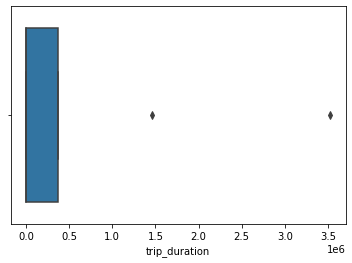

In [179]:
sns.boxplot(out_train['trip_duration'])

<AxesSubplot:xlabel='trip_duration'>

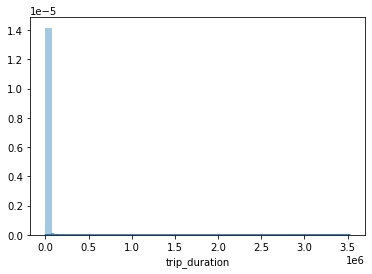

In [180]:
sns.distplot(train.trip_duration)

In [181]:
q99 = train.trip_duration.quantile(0.99)
q01 = train.trip_duration.quantile(0.01)

print('Quantile 0.01 = {} sec ({} min), quantile 0.99 = {} sec ({} min)'.format(
    q01,round(q01/60,2),q99,round(q99/60,2)))

Quantile 0.01 = 87.0 sec (1.45 min), quantile 0.99 = 3440.0 sec (57.33 min)


In [182]:
# removing observations with trip duration bigger than quantile 0.99 
# and smalle than quantile 0.01
train = train[train.trip_duration.between(q01,q99)]

<AxesSubplot:xlabel='trip_duration'>

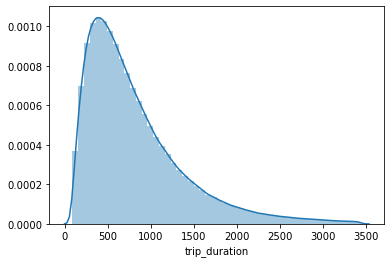

In [183]:
sns.distplot(train.trip_duration)

<AxesSubplot:xlabel='trip_duration'>

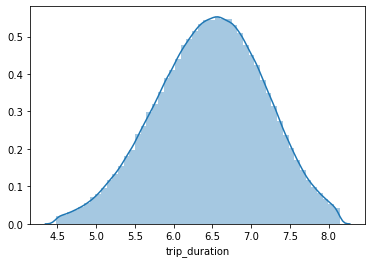

In [184]:
sns.distplot(np.log1p(train.trip_duration))

After logarithmic transformation distribution plot looks much better

In [262]:
# test
test = pd.read_csv(
    '/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/test.csv')

In [186]:
out_test = test[['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']].describe()

out_test.style.format("{:.6f}")

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000
mean,-73.973614,40.750927,-73.973458,40.751816
std,0.073389,0.029848,0.072565,0.035824
min,-121.933128,37.389587,-121.933327,36.601322
25%,-73.991852,40.737392,-73.991318,40.736000
50%,-73.981743,40.754093,-73.979774,40.754543
75%,-73.967400,40.768394,-73.963013,40.769852
max,-69.248917,42.814938,-67.496796,48.857597


In test we have also observations far away from nyc. I can do nothing in test set, so I let them be in train and also in test.

In [187]:
# amount of test set observations
test.count()[0]

625134

In [188]:
# combining train and test to make notebook less complex
test['trip_duration'] = -999
df = train.append(test)
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
625129,id3008929,1,2016-01-01 00:02:52,NaN,1,-74.003464,40.725105,-74.001251,40.733643,N,-999
625130,id3700764,1,2016-01-01 00:01:52,NaN,1,-74.006363,40.743782,-73.953407,40.782467,N,-999
625131,id2568735,1,2016-01-01 00:01:24,NaN,2,-73.972267,40.759865,-73.876602,40.748665,N,-999
625132,id1384355,1,2016-01-01 00:00:28,NaN,1,-73.976501,40.733562,-73.854263,40.891788,N,-999


In [189]:
# Adding pickup and dropoff neighborhoods seems to be a good idea to better catch "border crossing" trips
# thanks to geopandas package we can do it easily
boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))

In [190]:
boroughs

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330385.03697,1.623853e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,4,Queens,861038.47930,3.049947e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,3,Brooklyn,726568.94634,1.959432e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,1,Manhattan,358532.95642,6.364422e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,464517.89055,1.186804e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


### Adding pickup borough to dataframe
this section takes a while

In [191]:
%%time

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.pickup_longitude, 
                                    df.pickup_latitude))

CPU times: user 16.3 s, sys: 282 ms, total: 16.5 s
Wall time: 16.6 s


In [192]:
%%time

trips_with_boro = gpd.sjoin(gdf, boroughs, how="left", op='intersects')

CPU times: user 7min 12s, sys: 1.1 s, total: 7min 13s
Wall time: 7min 13s


In [194]:
cols_to_dro = ['index_right','BoroCode','Shape_Leng','Shape_Area','geometry']
trips_with_boro = trips_with_boro.drop(cols_to_dro, axis=1)
trips_with_boro = trips_with_boro.rename(columns={'BoroName': 'pickup_boro'})

### Adding dropoff borough to dataframe

In [195]:
%%time

gdf = gpd.GeoDataFrame(
    trips_with_boro, geometry=gpd.points_from_xy(trips_with_boro.dropoff_longitude, 
                                                 trips_with_boro.dropoff_latitude))

CPU times: user 16 s, sys: 364 ms, total: 16.3 s
Wall time: 16.3 s


In [196]:
%%time

trips_with_boro = gpd.sjoin(gdf, boroughs, how="left", op='intersects')

CPU times: user 7min 22s, sys: 1.09 s, total: 7min 23s
Wall time: 7min 23s


In [197]:
cols_to_dro = ['index_right','BoroCode','Shape_Leng','Shape_Area','geometry']
trips_with_boro = trips_with_boro.drop(cols_to_dro, axis=1)
trips_with_boro = trips_with_boro.rename(columns={'BoroName': 'dropoff_boro'})

## Distnace

In [198]:
# distances from pickup point to dropoff point by geodesic measure
p_lat = trips_with_boro['pickup_latitude'].to_list()
p_lon = trips_with_boro['pickup_longitude'].to_list()
d_lat = trips_with_boro['dropoff_latitude'].to_list()
d_lon = trips_with_boro['dropoff_longitude'].to_list()

dists = []
for row in tqdm(range(len(p_lon))):
    x = geopy.distance.geodesic((p_lat[row], p_lon[row]), (d_lat[row], d_lon[row])).miles
    dists.append(x)
    
trips_with_boro['distance'] = dists

### Checkpoint 
Cells before were a little bit time-consuming so checkpoint is needed

In [199]:
csv = trips_with_boro.to_csv('/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/checkpoint1.csv')

In [366]:
df = pd.read_csv('/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/checkpoint1.csv', index_col=0)

In [367]:
def count_null_rows(data_frame):
    """
    Counting percentage of missing data by columns.
    """
    counter = (len(data_frame) - data_frame.count())
    percent = counter/len(data_frame) 
    frame = pd.concat([counter, percent], axis=1)
    frame = frame.rename(columns={0: 'r', 1: '%'})
    frame['%'] = round(frame['%']*100, 2)
    return frame.sort_values(by=frame.columns[0], ascending=True)       

In [368]:
count_null_rows(df)

,r,%
id,0,0.00
vendor_id,0,0.00
pickup_datetime,0,0.00
passenger_count,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
store_and_fwd_flag,0,0.00
trip_duration,0,0.00


dropoff_datetime has 30% nulls because it's also a test set here. Lacks in pickup_boro and dropoff_boro means that some of trips was from or to places outside New York City. I fill null values there with string 'other'.

In [369]:
df['pickup_boro'] = df['pickup_boro'].fillna('other')
df['dropoff_boro'] = df['dropoff_boro'].fillna('other')

## "Border crossing" trips

In [370]:
# trips to other districts of nyc

In [371]:
df['boarder_cross'] = np.where(df['pickup_boro']!=df['dropoff_boro'], 1, 0)

In [372]:
# trips from outside and to outside nyc

In [373]:
df['from_outside'] = np.where((df['pickup_boro']=='other') & (df['dropoff_boro']!='other'), 1, 0)

In [374]:
df['to_outside'] = np.where((df['pickup_boro']!='other') & (df['dropoff_boro']=='other'), 1, 0)

## Encoding store store_and_fwd_flag feature 

In [375]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

## Dealing with date

In [376]:
year = []
month = []
day = []

dates = df['pickup_datetime']
for row in tqdm(dates):
    year.append(row[0:4])
    month.append(row[5:7])
    day.append(row[8:10])
    
df['year'] = year
df['month'] = month
df['day'] = day

In [377]:
df['year'] = df['year'].astype('int64')
df['month'] = df['month'].astype('int64')
df['day'] = df['day'].astype('int64')

### Weekdays

In [378]:
year = df['year'].to_list()
month = df['month'].to_list()
day = df['day'].to_list()
day_of_the_week = []

for row in tqdm(range(len(df))):
    day_of_the_week.append(datetime(year[row],month[row],day[row]).weekday())

df['day_of_the_week'] = day_of_the_week

In [379]:
df['day_of_the_week'] = df['day_of_the_week'].map({0: 'Sunday',
                                                   1: 'Monday',
                                                   2: 'Tuesday',
                                                   3: 'Wednesday',
                                                   4: 'Thursday',
                                                   5: 'Friday', 
                                                   6: 'Saturday'})

### Holidays

In [380]:
us_holidays = holidays.CountryHoliday('US', prov=None, state='NY', years=2016)
is_holiday = []

for row in tqdm(range(len(df))):
    if datetime(year[row],month[row],day[row]) in us_holidays:
        is_holiday.append(1)
    else:
        is_holiday.append(0)        

df['is_holiday'] = is_holiday

### Hours

In [381]:
# hour when trip started
pickup_date = df['pickup_datetime'].to_list()
hour = []

for row in tqdm(range(len(df))):
    hour.append(pickup_date[row][11:13])

df['full_hour'] = hour

In [382]:
df['full_hour'] = df['full_hour'].astype('int64')

In [383]:
# day / night
full_hour = df['full_hour'].to_list()
day = []
night = [] 

for row in tqdm(range(len(df))):
    if full_hour[row] >= 6 and full_hour[row] <= 20:
        day.append(1)
        night.append(0)
    else:
        day.append(0)
        night.append(1)
        
df['is_day'] = day
df['is_night'] = night

In [384]:
# weekend or not
weekend = df['day_of_the_week'].to_list()
is_weekend = []

for row in tqdm(range(len(df))):
    if weekend[row] == 'Saturday':
        is_weekend.append(1)
    elif weekend[row] == 'Sunday':
        is_weekend.append(1)
    else:
        is_weekend.append(0)
        
df['is_weekend'] = is_weekend

In [385]:
# heavy rush in NY is between 6AM and 10AM and also between 3PM and 6PM
full_hour = df['full_hour'].to_list()
heavy_rush = []

for row in tqdm(range(len(df))):
    if full_hour[row] >= 6 and full_hour[row] <= 10 and is_weekend[row] != 1 and is_holiday != 1:
        heavy_rush.append(1)
    elif full_hour[row] >= 15 and full_hour[row] <= 18 and is_weekend[row] != 1 and is_holiday != 1:
        heavy_rush.append(1)
    else:
        heavy_rush.append(0)

df['is_heavy_rush'] = heavy_rush

In [386]:
# minute of the day
df['minute'] = df['pickup_datetime'].str[14:16].astype('int64')

### Following days

In [392]:
df['day_of_the_year'] = df['pickup_datetime'].str[0:10]
df = df.sort_values(by='day_of_the_year')

df['day_of_the_year'] = pd.factorize(df['day_of_the_year'])[0]

## Encoding of categorical columns

In [395]:
def get_boolean_from_categorical(data_frame, col_name, leave_nans=True):
    """
    Creating as much new columns as unique values are in original column.
    New columns are in a style is_value_name_(original_column_name) and 
    are fulfilled with binary values, if specific observation have particular 
    value in original column, new value will be 1, in other cases 0. Parameter 
    leave_nans, by default set as True, specify if missing values will be 0 or 
    original. This function in fact is something like 'scikit learn's one-hot 
    encoding' functions.
    """
    list_of_items = data_frame[col_name].unique().tolist()
    if np.nan in list_of_items: 
        list_of_items.remove(np.nan)
    for elem in range(len(list_of_items)):
        x = list_of_items[elem]
        name = 'is_' + list_of_items[elem] + '_(' + col_name + ')'
        bool_list = []
        for i in data_frame[col_name]:
            if  leave_nans is True:
                if x == i:
                    bool_list.append(1)
                elif isinstance(i, float) == True:                                                                            
                    bool_list.append(np.nan)
                else:
                    bool_list.append(0)
            else:
                if x == i:
                    bool_list.append(1)
                else:
                    bool_list.append(0)
        data_frame[name] = bool_list
        if  leave_nans is True: 
            data_frame[name] = data_frame[name].astype("Int64") 
        else:
            data_frame[name] = data_frame[name].astype("int64") 
    return data_frame[name] 

In [396]:
cols = ['day_of_the_week', 'vendor_id', 'pickup_boro', 'dropoff_boro']

In [397]:
for col in tqdm(cols):
    df[col] = df[col].astype('str')
    get_boolean_from_categorical(data_frame=df, col_name=col)
    df = df.drop(col, axis=1)

### Drop

In [394]:
# Droping not needed features
df = df.drop('pickup_datetime', axis=1)
df = df.drop('dropoff_datetime', axis=1)
df = df.drop('year', axis=1)
# df = df.drop('month', axis=1)
# df = df.drop('day', axis=1)
# df = df.drop('full_hour', axis=1)

In [398]:
# train test split
train = df[df['trip_duration']>-1]
test = df[df['trip_duration']==-999]
test = test.drop('trip_duration', axis=1)

## Saving

In [401]:
train

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,boarder_cross,from_outside,to_outside,month,day,is_holiday,full_hour,is_day,is_night,is_weekend,is_heavy_rush,minute,day_of_the_year,is_Thursday_(day_of_the_week),is_Friday_(day_of_the_week),is_Saturday_(day_of_the_week),is_Sunday_(day_of_the_week),is_Monday_(day_of_the_week),is_Tuesday_(day_of_the_week),is_Wednesday_(day_of_the_week),is_2_(vendor_id),is_1_(vendor_id),is_Manhattan_(pickup_boro),is_Brooklyn_(pickup_boro),is_Queens_(pickup_boro),is_Bronx_(pickup_boro),is_other_(pickup_boro),is_Staten Island_(pickup_boro),is_Manhattan_(dropoff_boro),is_Brooklyn_(dropoff_boro),is_Queens_(dropoff_boro),is_Bronx_(dropoff_boro),is_other_(dropoff_boro),is_Staten Island_(dropoff_boro)
1350369,id1558311,1,-74.004364,40.721954,-73.992821,40.737339,0,349,1.222336,0,0,0,1,1,1,3,0,1,0,0,42,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
1350340,id3967999,1,-73.992325,40.769135,-73.988953,40.726994,0,972,2.913219,0,0,0,1,1,1,4,0,1,0,0,43,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
1350045,id0875526,1,-73.963486,40.675667,-73.984970,40.663467,0,620,1.408094,0,0,0,1,1,1,3,0,1,0,0,32,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
1349810,id2792877,1,-73.870743,40.773609,-73.976357,40.744122,0,791,5.903221,1,0,0,1,1,1,14,1,0,0,0,23,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1349587,id2873495,1,-73.972702,40.793411,-73.982178,40.769554,0,493,1.719606,0,0,0,1,1,1,10,1,0,0,1,36,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308888,id2694311,1,-73.969849,40.759747,-73.987503,40.740864,0,1112,1.598745,0,0,0,6,30,0,19,1,0,0,0,38,181,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0
268669,id2284700,1,-73.996315,40.743385,-73.991180,40.717319,0,1705,1.818688,0,0,0,6,30,0,19,1,0,0,0,43,181,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0
1396789,id3899436,1,-73.870796,40.773602,-73.898109,40.743408,0,1194,2.528728,0,0,0,6,30,0,6,1,0,0,1,12,181,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
589327,id1965209,2,-73.984352,40.759190,-73.979492,40.787010,0,1386,1.936558,0,0,0,6,30,0,17,1,0,0,1,32,181,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0


In [400]:
csv = train.to_csv('/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/train_processed.csv')
csv = test.to_csv('/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/test_processed.csv')